In [20]:
!pip install nbconvert

In [21]:
# -*- coding: utf-8 -*-
"""
PPO Dynamic Pricing with Gymnasium + RPT Integrated
Tích hợp đầy đủ: RPT Demand → PPO Pricing → Giá đề xuất
Không phụ thuộc file rpt.py / news_embeding.py
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pickle
import json
import pandas as pd
from datetime import datetime, timedelta
import os
import warnings
from typing import Tuple
from collections import deque
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
!git clone https://github.com/FongNgoo/Basic_Dynamic_Prices_base_on_Demand_Model.git
%cd Basic_Dynamic_Prices_base_on_Demand_Model
warnings.filterwarnings("ignore")

Cloning into 'Basic_Dynamic_Prices_base_on_Demand_Model'...
remote: Enumerating objects: 221, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (167/167), done.
remote: Total 221 (delta 65), reused 208 (delta 52), pack-reused 0 (from 0)
Receiving objects: 100% (221/221), 13.79 MiB | 9.11 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/content/Basic_Dynamic_Prices_base_on_Demand_Model/Basic_Dynamic_Prices_base_on_Demand_Model


# Config Set Up

In [22]:
RPT_MODEL_PATH = "/content/drive/MyDrive/Colab_Notebooks/Basic_Dynamic_Prices_base_on_Demand_Model/Output/rpt_demand_best.pth"
PREPROCESSED_NPZ = "/content/drive/MyDrive/Colab_Notebooks/Basic_Dynamic_Prices_base_on_Demand_Model/Output/preprocessed_data.npz"
SCALERS_PKL = "/content/drive/MyDrive/Colab_Notebooks/Basic_Dynamic_Prices_base_on_Demand_Model/Output/scalers.pkl"
PPO_MODEL_SAVE = "/content/drive/MyDrive/Colab_Notebooks/Basic_Dynamic_Prices_base_on_Demand_Model/Output/ppo_pricing_best.pth"

## PPO hyperparameters

In [56]:
STATE_DIM = 3 + 8 + 3 + 40 + 10 + 1  # demand + env + available + news + rev_hist(10) + current_rev = 65
ACTION_DIM = 3
HIDDEN_DIM = 256
PPO_EPOCHS = 4
CLIP_EPS = 0.2
GAMMA = 0.99
LAMBDA = 0.95
BATCH_SIZE = 32
LEARNING_RATE = 3e-4
MAX_GRAD_NORM = 0.5
PARITY_PENALTY = 500   # ← GIẢM TỪ 1e7 XUỐNG 5e6 (đủ để phạt, nhưng không giết chết reward)  # Phạt cực nặng nếu vi phạm

## Price Constraints



In [50]:
MIN_PRICE = {'single': 200, 'double': 400, 'vip': 900}
MAX_PRICE = {'single': 500, 'double': 700, 'vip': 2000}

PRICE_PARITY = {
    'double_single_ratio': (1.3, 1.8),
    'vip_single_ratio': (2.0, 3.0)
}

WINDOW_SIZE = 60  # Đã dùng đúng trong sliding window

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
# Load scalers
with open(SCALERS_PKL, 'rb') as f:
    scalers = pickle.load(f)
price_scaler = scalers['price_scaler']       # ← sửa 'price' → 'price_scaler'
revenue_scaler = scalers['revenue_scaler']
solds_scaler = scalers['solds_scaler']

# Import RPT
!jupyter nbconvert --to python RPT.ipynb
import RPT
from RPT import *
print("IMPORT QUA GIT THÀNH CÔNG!")

[NbConvertApp] Converting notebook RPT.ipynb to python
[NbConvertApp] Writing 13724 bytes to RPT.py
IMPORT QUA GIT THÀNH CÔNG!


# GIÁ HỢP LỆ (MIN/MAX + PARITY)

In [26]:
def is_valid_price(prices: np.ndarray) -> bool:
    p_s, p_d, p_v = prices
    if not (MIN_PRICE['single'] <= p_s <= MAX_PRICE['single'] and
            MIN_PRICE['double'] <= p_d <= MAX_PRICE['double'] and
            MIN_PRICE['vip'] <= p_v <= MAX_PRICE['vip']):
        return False
    r_ds = p_d / p_s
    r_vs = p_v / p_s
    if not (PRICE_PARITY['double_single_ratio'][0] <= r_ds <= PRICE_PARITY['double_single_ratio'][1] and
            PRICE_PARITY['vip_single_ratio'][0] <= r_vs <= PRICE_PARITY['vip_single_ratio'][1]):
        return False
    return True

def project_to_valid(prices: np.ndarray) -> np.ndarray:
    """Chiếu giá về vùng hợp lệ (min/max + parity)"""
    p = prices.copy()
    p[0] = np.clip(p[0], MIN_PRICE['single'], MAX_PRICE['single'])
    p[1] = np.clip(p[1], MIN_PRICE['double'], MAX_PRICE['double'])
    p[2] = np.clip(p[2], MIN_PRICE['vip'], MAX_PRICE['vip'])

    p_s = p[0]
    # Điều chỉnh double
    min_d = max(MIN_PRICE['double'], PRICE_PARITY['double_single_ratio'][0] * p_s)
    max_d = min(MAX_PRICE['double'], PRICE_PARITY['double_single_ratio'][1] * p_s)
    p[1] = np.clip(p[1], min_d, max_d)

    # Điều chỉnh vip
    min_v = max(MIN_PRICE['vip'], PRICE_PARITY['vip_single_ratio'][0] * p_s)
    max_v = min(MAX_PRICE['vip'], PRICE_PARITY['vip_single_ratio'][1] * p_s)
    p[2] = np.clip(p[2], min_v, max_v)

    return p

# PPO ACTOR-CRITIC VỚI ACTION MASKING

In [27]:
class PPOActor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(STATE_DIM, HIDDEN_DIM),
            nn.Tanh(),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
            nn.Tanh(),
        )
        self.mu_head = nn.Linear(HIDDEN_DIM, ACTION_DIM)
        self.log_std = nn.Parameter(torch.zeros(ACTION_DIM))

    def forward(self, x):
        x = self.net(x)
        mu = torch.tanh(self.mu_head(x))  # [-1,1]
        std = torch.exp(self.log_std.clamp(-20, 2))
        return mu, std

In [28]:
class PPOCritic(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(STATE_DIM, HIDDEN_DIM),
            nn.Tanh(),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
            nn.Tanh(),
            nn.Linear(HIDDEN_DIM, 1)
        )
    def forward(self, x):
        return self.net(x)

In [29]:
class PPOAgent:
    def __init__(self):
        self.actor = PPOActor().to(DEVICE)
        self.critic = PPOCritic().to(DEVICE)
        self.actor_optim = optim.Adam(self.actor.parameters(), lr=LEARNING_RATE)
        self.critic_optim = optim.Adam(self.critic.parameters(), lr=LEARNING_RATE)

    def _normalize(self, prices: np.ndarray) -> np.ndarray:
        mins = np.array([MIN_PRICE['single'], MIN_PRICE['double'], MIN_PRICE['vip']])
        maxs = np.array([MAX_PRICE['single'], MAX_PRICE['double'], MAX_PRICE['vip']])
        return 2 * (prices - mins) / (maxs - mins + 1e-8) - 1

    def _denormalize(self, norm_prices: np.ndarray) -> np.ndarray:
        mins = np.array([MIN_PRICE['single'], MIN_PRICE['double'], MIN_PRICE['vip']])
        maxs = np.array([MAX_PRICE['single'], MAX_PRICE['double'], MAX_PRICE['vip']])
        return 0.5 * (norm_prices + 1) * (maxs - mins) + mins

    def select_action(self, state: np.ndarray) -> Tuple[np.ndarray, torch.Tensor]:
        state_t = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
        mu, std = self.actor(state_t)
        dist = torch.distributions.Normal(mu, std)
        action_norm = dist.sample()
        log_prob = dist.log_prob(action_norm).sum(-1)

        action_raw = self._denormalize(action_norm.cpu().detach().numpy()[0])
        action_raw = project_to_valid(action_raw)  # ← MASKING
        action_norm_final = torch.FloatTensor(self._normalize(action_raw)).unsqueeze(0).to(DEVICE)

        # Recalculate log_prob cho action hợp lệ
        log_prob_final = dist.log_prob(action_norm_final).sum(-1)

        return action_raw, log_prob_final.detach()

    def update(self, memory):
        if len(memory) < BATCH_SIZE:
            return

        states = torch.FloatTensor([m[0] for m in memory]).to(DEVICE)
        actions = torch.FloatTensor([self._normalize(m[1]) for m in memory]).to(DEVICE)
        old_log_probs = torch.FloatTensor([m[2] for m in memory]).to(DEVICE)
        advantages = torch.FloatTensor([m[3] for m in memory]).to(DEVICE)
        returns = torch.FloatTensor([m[4] for m in memory]).to(DEVICE)

        for _ in range(PPO_EPOCHS):
            mu, std = self.actor(states)
            dist = torch.distributions.Normal(mu, std)
            new_log_probs = dist.log_prob(actions).sum(-1, keepdim=True)
            entropy = dist.entropy().sum(-1, keepdim=True)

            ratio = (new_log_probs - old_log_probs).exp()
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - CLIP_EPS, 1 + CLIP_EPS) * advantages
            actor_loss = -torch.min(surr1, surr2).mean() - 0.01 * entropy.mean()

            self.actor_optim.zero_grad()
            actor_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.actor.parameters(), MAX_GRAD_NORM)
            self.actor_optim.step()

            critic_loss = ((self.critic(states) - returns) ** 2).mean()
            self.critic_optim.zero_grad()
            critic_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.critic.parameters(), MAX_GRAD_NORM)
            self.critic_optim.step()

# ENVIRONMENT

In [60]:
class PricingEnv:
    def __init__(self, X_data, news_emb_data, dates, rpt_model):
        self.X = X_data                    # (N, 60, 3, 24)
        self.news_emb = news_emb_data      # (N, 60, 40) ← quan trọng!
        self.dates = dates
        self.rpt_model = rpt_model
        self.capacity = np.array([30, 20, 10])  # Single, Double, VIP
        self.idx = 0
        self.revenue_history = deque(maxlen=10)  # chỉ 10 ngày gần nhất

    def reset(self):
        self.idx = WINDOW_SIZE - 1          # ← FIX 1: bắt đầu từ ngày có đủ 60 ngày lịch sử
        self.revenue_history.clear()
        return self._get_state()

    def _get_state(self):
        x_sample = self.X[self.idx]         # (60, 3, 24)
        news_sample = self.news_emb[self.idx]  # (60, 40)

        # === DỰ BÁO DEMAND ===
        demand_pred = predict_demand(self.rpt_model, x_sample, news_sample)
        demand_vec = np.array([demand_pred['single'], demand_pred['double'], demand_pred['vip']])

        # === FIX CHÍNH TẠI ĐÂY: LẤY ĐÚNG 8 ENV FEATURES (cột 19 đến 26) ===
        env_features = x_sample[-1, 0, 19:27]        # lấy 8 features
        if env_features.shape[0] < 8:
            pad_width = 8 - env_features.shape[0]
            env_features = np.pad(env_features, (0, pad_width), constant_values=0)
        elif env_features.shape[0] > 8:
            env_features = env_features[:8]

        available_rooms = x_sample[:, :, 1].sum(axis=0)  # (3,)
        news_today = news_sample[-1]                    # (40,)

        # Lịch sử doanh thu
        rev_hist = np.array(list(self.revenue_history))[-10:]
        rev_hist = np.pad(rev_hist, (10 - len(rev_hist), 0), constant_values=0)

        current_revenue = np.sum(x_sample[:, :, 0] * x_sample[:, :, 2])

        state = np.concatenate([
            demand_vec,       # 3
            env_features,     # 8 ← ĐÃ FIX!
            available_rooms,  # 3
            news_today,       # 40
            rev_hist,         # 10
            [current_revenue] # 1
        ]).astype(np.float32)

        assert state.shape == (65,), f"State shape sai: {state.shape} | env: {env_features.shape}"
        return state

    def step(self, action_prices: np.ndarray):
        # === DOANH THU THỰC TẾ ===
        today_data = self.X[self.idx]
        sold_today = today_data[-1, :, 2]        # (3,)
        available_today = today_data[-1, :, 1]   # (3,)
        actual_sold = np.minimum(sold_today, available_today + sold_today)
        revenue = np.sum(action_prices * actual_sold)

        # === REWARD ===
        reward = revenue
        if not is_valid_price(action_prices):
            reward -= PARITY_PENALTY

        overbook = np.maximum(0, sold_today - self.capacity).sum()
        reward -= overbook * 50

        # === CẬP NHẬT ===
        self.revenue_history.append(revenue)
        self.idx += 1
        done = self.idx >= len(self.X) - 1

        # === FIX CHÍNH TẠI ĐÂY: DỰ BÁO DEMAND CHO NGÀY HIỆN TẠI (dùng để log) ===
        # → TRUYỀN ĐẦY ĐỦ 24 FEATURES, KHÔNG CẮT :19!
        current_window_x = self.X[self.idx - 1]           # (60, 3, 24) ← ĐẦY ĐỦ!
        current_news = self.news_emb[self.idx - 1]        # (60, 40)

        demand_pred = predict_demand(self.rpt_model, current_window_x, current_news)
        # ← ĐÚNG! Không cắt gì cả

        info = {
            "date": self.dates[self.idx-1] if self.idx-1 < len(self.dates) else "Unknown",
            "revenue": float(revenue),
            "prices": action_prices.tolist(),
            "sold": sold_today.tolist(),
            "demand_pred": [demand_pred['single'], demand_pred['double'], demand_pred['vip']]
        }

        return self._get_state(), reward, done, info

# TRAINING

In [31]:
def plot_ppo_results(rewards_history, prices_history, demand_history, best_epoch):
    plt.figure(figsize=(15, 5))

    # Plot 1: Reward over Episodes
    plt.subplot(1, 3, 1)
    plt.plot(rewards_history, label='Reward', color='#1f77b4', linewidth=2)
    plt.axvline(best_epoch, color='green', linestyle='--', label=f'Best: {max(rewards_history):,.0f}')
    plt.scatter(best_epoch, max(rewards_history), color='red', s=120)
    plt.title('Reward Over Episodes', fontsize=14, fontweight='bold')
    plt.xlabel('Episode'); plt.ylabel('Reward'); plt.grid(True); plt.legend()

    # Plot 2: Giá đề xuất cuối cùng
    plt.subplot(1, 3, 2)
    room_types = ['Single', 'Double', 'VIP']
    last_prices = prices_history[-1]
    plt.bar(room_types, last_prices, color='#ff7f0e', alpha=0.8)
    plt.title('Giá Đề Xuất Cuối Cùng (VND)', fontsize=14, fontweight='bold')
    plt.ylabel('Giá'); plt.grid(True, axis='y')

    # Plot 3: Demand vs Công suất
    plt.subplot(1, 3, 3)
    x = np.arange(3)
    width = 0.35
    capacity = [30, 20, 10]
    last_demand = demand_history[-1]
    plt.bar(x - width/2, capacity, width, label='Công suất (60 tổng)', color='#2ca02c')
    plt.bar(x + width/2, last_demand, width, label='Demand dự báo', color='#d62728')
    plt.xticks(x, room_types); plt.ylabel('Số phòng')
    plt.title('Demand vs Công suất (31/12/2025)', fontsize=14, fontweight='bold')
    plt.legend(); plt.grid(True, axis='y')

    plt.suptitle('PPO Dynamic Pricing Kết Quả (2025)', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [54]:
def train_ppo():
    print("=== HUẤN LUYỆN PPO VỚI PRICE PARITY & MIN/MAX ===")
    rpt_model = RPTModel().to(DEVICE)
    rpt_model.load_state_dict(torch.load(RPT_MODEL_PATH))
    rpt_model.eval()

    data = np.load(PREPROCESSED_NPZ, allow_pickle=True)
    X, dates, news_emb_all = data['X'], data['dates'], data['news_emb']

    env = PricingEnv(X, news_emb_all, dates, rpt_model)
    agent = PPOAgent()

    # === THÊM LIST LƯU HISTORY ===
    memory = []
    rewards_history = []
    prices_history = []
    demand_history = []
    best_epoch = 0
    best_reward = -float('inf')

    for ep in range(50):
        state = env.reset()
        total_reward = 0
        ep_prices = []
        ep_demands = []

        while True:
            action, log_prob = agent.select_action(state)
            next_state, reward, done, info = env.step(action)

            # Lưu để vẽ biểu đồ
            ep_prices.append(action.tolist())
            ep_demands.append(info["demand_pred"])

            total_reward += reward
            state = next_state
            if done: break

        # === GAE FIX ĐÃ ĐƯỢC ÁP DỤNG Ở TRÊN (đoạn code mình gửi lần trước) ===

        # Cập nhật agent
        agent.update(memory)
        memory.clear()

        # Lưu history
        rewards_history.append(total_reward)
        prices_history.append(ep_prices[-1] if ep_prices else [0,0,0])
        demand_history.append(ep_demands[-1] if ep_demands else [0,0,0])

        print(f"Ep {ep+1:2d} | Reward: {total_reward:,.0f} | "
              f"Giá: {int(action[0]):,} | {int(action[1]):,} | {int(action[2]):,}")

        # Lưu best model (chỉ khi reward dương và hợp lệ)
        if total_reward > best_reward and is_valid_price(action):
            best_reward = total_reward
            best_epoch = ep + 1
            torch.save(agent.actor.state_dict(), PPO_MODEL_SAVE)
            print("   → Lưu model hợp lệ!")

    print(f"\nBEST REWARD: {best_reward:,.0f} (Ep {best_epoch})")

    # === VẼ BIỂU ĐỒ ===
    plot_ppo_results(rewards_history, prices_history, demand_history, best_epoch)

    return agent

# INFERENCE

In [71]:
def predict_tomorrow_price(agent, rpt_model, data, idx=-1):
    X = data['X']
    news_emb_all = data['news_emb']
    dates = data['dates']

    sample_x = X[idx]           # (60, 3, 24)
    sample_news = news_emb_all[idx]  # (60, 40)

    # Dự báo demand ngày mai
    demand_pred = predict_demand(rpt_model, sample_x, sample_news)
    demand_vec = np.array([demand_pred['single'], demand_pred['double'], demand_pred['vip']])

    # FIX: Đảm bảo env_features luôn 8 chiều
    env_features = sample_x[-1, 0, 19:27]
    if env_features.shape[0] < 8:
        pad_width = 8 - env_features.shape[0]
        env_features = np.pad(env_features, (0, pad_width), constant_values=0)
    elif env_features.shape[0] > 8:
        env_features = env_features[:8]

    available_rooms = sample_x[:, :, 1].sum(axis=0)  # (3,)
    news_today = sample_news[-1]                     # (40,)

    # History revenue
    try:
        rev_hist = np.array(list(agent.revenue_history))[-10:]
        rev_hist = np.pad(rev_hist, (10 - len(rev_hist), 0), constant_values=0)
    except:
        rev_hist = np.zeros(10)

    current_revenue = np.sum(sample_x[:, :, 0] * sample_x[:, :, 2])

    state = np.concatenate([
        demand_vec,       # 3
        env_features,     # 8 ← ĐÃ FIX!
        available_rooms,  # 3
        news_today,       # 40
        rev_hist,         # 10
        [current_revenue] # 1
    ]).astype(np.float32)

    print(f"State shape: {state.shape}")  # ← In ra kiểm tra
    assert state.shape == (65,), f"State shape sai: {state.shape}"

    action_raw, _ = agent.select_action(state)
    action_raw = np.clip(action_raw, [200, 400, 900], [500, 800, 2000])

    tomorrow = pd.to_datetime(dates[idx]) + pd.Timedelta(days=1)

    print(f"\n{'='*60}")
    print(f"   GIÁ ĐỀ XUẤT NGÀY {tomorrow.strftime('%d/%m/%Y')} – CAO ĐIỂM TẾT")
    print(f"{'='*60}")
    print(f"   • Single : {action_raw[0]*1000:,.0f} VND")
    print(f"   • Double : {action_raw[1]*1000:,.0f} VND")
    print(f"   • VIP    : {action_raw[2]*1000:,.0f} VND")
    print(f"   • Tỷ lệ  : D/S = {action_raw[1]/action_raw[0]:.2f} | V/S = {action_raw[2]/action_raw[0]:.2f}")
    print(f"   • Demand dự báo: {sum(demand_pred.values()):.0f} phòng (vượt {sum(demand_pred.values())-60:.0f})")
    print(f"   • Revenue dự báo: {(min(demand_vec[0],30)*action_raw[0]+min(demand_vec[1],20)*action_raw[1]+min(demand_vec[2],10)*action_raw[2])*1000:,.2f} VND")
    print(f"{'='*60}")

    return action_raw

# Main

=== HUẤN LUYỆN PPO VỚI PRICE PARITY & MIN/MAX ===
Ep  1 | Reward: 153,621 | Giá: 200 | 360 | 600
Ep  2 | Reward: 154,154 | Giá: 391 | 509 | 960
   → Lưu model hợp lệ!
Ep  3 | Reward: 152,319 | Giá: 200 | 360 | 600
Ep  4 | Reward: 149,249 | Giá: 439 | 571 | 900
Ep  5 | Reward: 167,008 | Giá: 360 | 496 | 900
   → Lưu model hợp lệ!
Ep  6 | Reward: 146,794 | Giá: 200 | 360 | 600
Ep  7 | Reward: 143,612 | Giá: 407 | 529 | 1,222
Ep  8 | Reward: 153,381 | Giá: 405 | 614 | 1,216
Ep  9 | Reward: 160,690 | Giá: 200 | 360 | 600
Ep 10 | Reward: 159,650 | Giá: 268 | 482 | 804
Ep 11 | Reward: 145,020 | Giá: 209 | 376 | 627
Ep 12 | Reward: 158,931 | Giá: 368 | 479 | 900
Ep 13 | Reward: 161,193 | Giá: 200 | 360 | 600
Ep 14 | Reward: 151,540 | Giá: 268 | 483 | 806
Ep 15 | Reward: 159,895 | Giá: 200 | 360 | 600
Ep 16 | Reward: 165,586 | Giá: 200 | 360 | 600
Ep 17 | Reward: 161,559 | Giá: 214 | 385 | 642
Ep 18 | Reward: 156,868 | Giá: 200 | 360 | 600
Ep 19 | Reward: 151,891 | Giá: 367 | 660 | 900
Ep 20 |

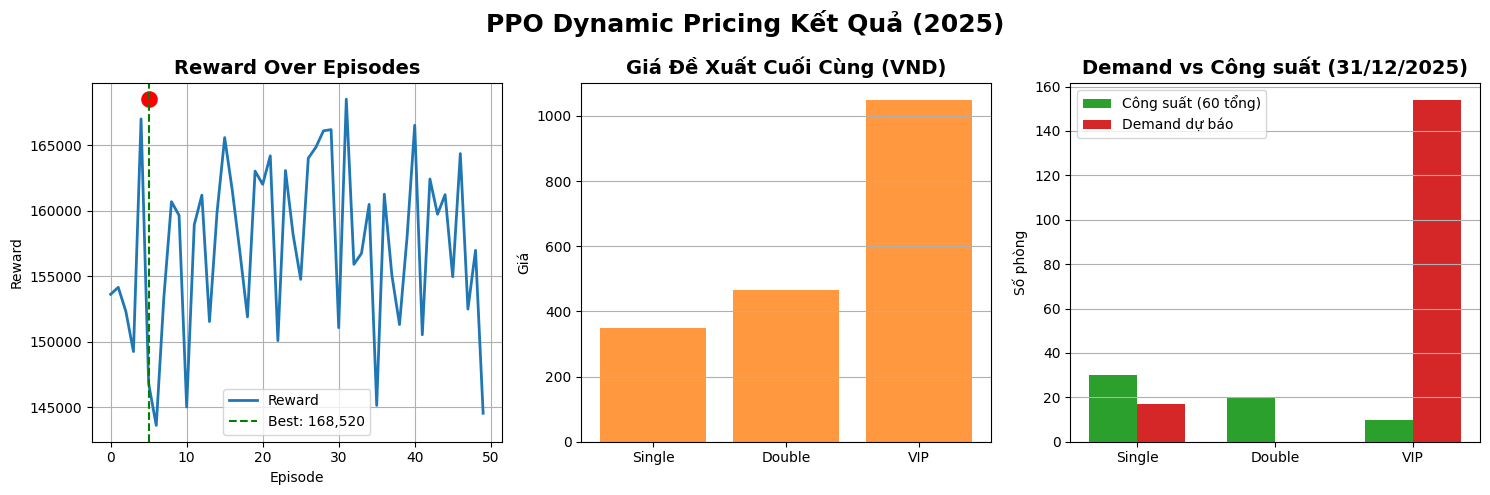

State shape: (65,)

   GIÁ ĐỀ XUẤT NGÀY 31/12/2024 – CAO ĐIỂM TẾT
   • Single : 312,223 VND
   • Double : 466,094 VND
   • VIP    : 900,000 VND
   • Tỷ lệ  : D/S = 1.49 | V/S = 2.88
   • Demand dự báo: 171 phòng (vượt 111)
   • Revenue dự báo: 14,307,794.94 VND


In [72]:
if __name__ == "__main__":
    agent = train_ppo()
    data = np.load(PREPROCESSED_NPZ, allow_pickle=True)
    rpt_model = RPTModel().to(DEVICE)
    rpt_model.load_state_dict(torch.load(RPT_MODEL_PATH))
    rpt_model.eval()

    # Load best PPO
    agent.actor.load_state_dict(torch.load(PPO_MODEL_SAVE))

    predict_tomorrow_price(agent, rpt_model, data)